# Semantic Search Engine

### This notebook contains an exemple on how to create a semantic search engine for conversational text, ranking the results based on relevance. 

In [1]:
!pip install sentence-transformers
!pip install textblob
!pip install faiss-cpu
!pip install bert-score

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


### Import libraries and load base bert model with 512 token limit

In [2]:
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
model_strategy_1 = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

### Import dataset

In [3]:
data = pd.read_csv('conversation_vtt.csv',memory_map=True)

In [4]:
data.head()


,index,text,end,start,user,index_column
0,0,"Okay, so we're recording. We're streaming",00:00:07.410,00:00:04.859,Andrew Knight,0
1,1,We have that setup. Okay.,00:00:12.990,00:00:09.540,Andrew Knight,1
2,2,It's like Mary Kate's here. I'll let her in.,00:00:17.760,00:00:15.630,Andrew Knight,2
3,3,Gonna make her a host to,00:00:21.240,00:00:19.980,Andrew Knight,3
4,4,She just got back from a vacation or something.,00:00:26.070,00:00:24.000,Paul McCartney,4


In [5]:
import gc
df = data[['index_column','text', "user", "start", "end"]]
del data
gc.collect()

9

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

In [7]:
df.head(100)

,index_column,text,user,start,end
0,0,"Okay, so we're recording. We're streaming",Andrew Knight,00:00:04.859,00:00:07.410
1,1,We have that setup. Okay.,Andrew Knight,00:00:09.540,00:00:12.990
2,2,It's like Mary Kate's here. I'll let her in.,Andrew Knight,00:00:15.630,00:00:17.760
3,3,Gonna make her a host to,Andrew Knight,00:00:19.980,00:00:21.240
4,4,She just got back from a vacation or something.,Paul McCartney,00:00:24.000,00:00:26.070
5,5,Mary Kate.,George Harrison,00:00:27.330,00:00:27.870
6,6,I think she was on a vacation for a while.,George Harrison,00:00:28.560,00:00:31.110
7,7,"Oh, nice. See how that one.",Ringo Starr,00:00:31.650,00:00:33.630
8,8,"America, Kate.",Andrew Knight,00:00:37.560,00:00:38.100
9,9,"Hi, how's it going good.",John Lennon,00:00:39.480,00:00:41.190


In [8]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['text'],inplace=True)

### Plot text length distribution

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


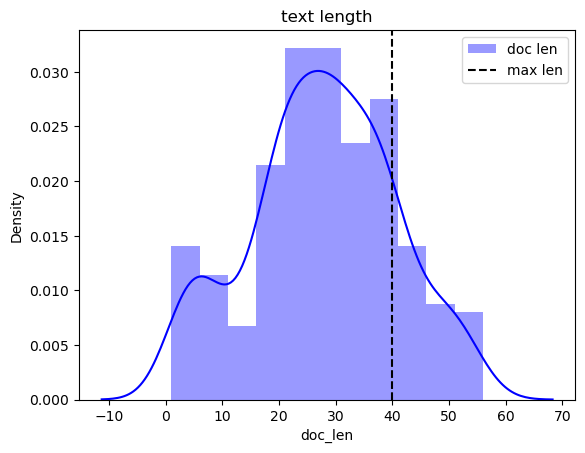

In [9]:
df['doc_len'] = df['text'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('text length'); plt.legend()
plt.show()

# Strategy 1
### The strategy below focus on converting the word embeddings in the dataset without fine tunning the model, generating a search index with faiss

In [10]:
import faiss
encoded_data = model_strategy_1.encode(df.text.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index_strategy_1 = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index_strategy_1.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index_strategy_1, 'conversation.index')

In [11]:
def fetch_conversation(dataframe_idx):
    info = df.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['index_column'] = info['index_column']
    meta_dict['user'] = info['user']
    meta_dict['end'] = info['end']
    meta_dict['text'] = info['text'][:500]
    return meta_dict
    
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_conversation(idx) for idx in top_k_ids]
    return results

In [12]:
from pprint import pprint

query="who is the professor of organizational behavior"
results_strategy_1=search(query, top_k=5, index=index_strategy_1, model=model_strategy_1)

results_strategy_1_df = pd.DataFrame(results_strategy_1)
results_strategy_1_df.head(5)

>>>> Results in Total Time: 0.017922639846801758


,index_column,user,end,text
0,39,Andrew Knight,00:10:45.120,My name is Andrew night. I'm a professor of organizational behavior in Olin business school. And I'm also the academic director of lifelong learning.
1,43,Andrew Knight,00:11:24.180,"for lifelong learning and so let me just share a couple of slides at the outset, before we welcome Professor liberty visitors who is going to be"
2,53,Andrew Knight,00:13:05.250,"Now as I mentioned at the start, we are so fortunate today to have with us. Professor liberty visitors."
3,54,Andrew Knight,00:13:14.520,Who is a Professor of Practice of data science here in the business school and she is someone who truly practices. What she preaches
4,55,Andrew Knight,00:13:24.300,She is active in disseminating her knowledge and expertise with respect to statistics data and analytics through so many different channels.


# Strategy 2
### Fine tunes the model using the conversation dataset with synthetic generated queries using the query-gen-msmarco-t5-large-v1 t5 model.
### One of the advantages of Strategy 2, compared with Strategy 1, is that if the generated syntetic queries are well defined the model could be much more capable of understanding similar expressions within the context of the dataset.

### Disclaimer
#### The current synthetic query generation technique is not yielding good results probably because the dataset was not pre processed correctly or due the dataset size. However, this is just a POC done in a 2-3 hours so I could not spend a good deal of time pre processing and analyzing the dataset. 

#### Creates paragraphs for conversations

In [13]:
paragraphs=df.text.tolist()

#### Imports t5 model

In [14]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
tokenizer = T5Tokenizer.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model = T5ForConditionalGeneration.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [15]:
#Select the device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [16]:
# Parameters for generation
batch_size = 16 #Batch size
num_queries = 5 #Number of queries to generate for every paragraph
max_length_paragraph = 512 #Max length for paragraph
max_length_query = 64   #Max length for output query

In [17]:
def _removeNonAscii(s): return "".join(i for i in s if ord(i) < 128)

#### Generates the syntetic queries to fine tune bert

In [18]:
def generate_synthetic_queries():
    with open('generated_queries_all.csv', 'w') as fOut:
        for start_idx in tqdm(range(0, len(paragraphs), batch_size)):
            sub_paragraphs = paragraphs[start_idx:start_idx+batch_size]
            inputs = tokenizer.prepare_seq2seq_batch(sub_paragraphs, max_length=max_length_paragraph, truncation=True, return_tensors='pt').to(device)
            outputs = model.generate(
                **inputs,
                max_length=max_length_query,
                do_sample=True,
                top_p=0.95,
                num_return_sequences=num_queries)

            for idx, out in enumerate(outputs):
                query = tokenizer.decode(out, skip_special_tokens=True)
                query = _removeNonAscii(query)
                para = sub_paragraphs[int(idx/num_queries)]
                para = _removeNonAscii(para)
                fOut.write("{}\t{}\n".format(query.replace("\t", " ").strip(), para.replace("\t", " ").strip()))

In [19]:
generate_synthetic_queries()

  0%|          | 0/19 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:3707: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
100%|██████████| 19/19 [04:55<00:00, 15.54s/it]


In [20]:
synthetic_queries = pd.read_csv('generated_queries_all.csv',memory_map=True,sep='\t')

In [21]:
synthetic_queries.head(200)

,what's up with stream on the tv screen,"Okay, so we're recording. We're streaming"
0,streaming,"Okay, so we're recording. We're streaming"
1,is this video recorded?,"Okay, so we're recording. We're streaming"
2,is the stream live,"Okay, so we're recording. We're streaming"
3,is streaming okay,"Okay, so we're recording. We're streaming"
4,who has the setup to check in with ctesa?,We have that setup. Okay.
5,what does ps4 mean,We have that setup. Okay.
6,do you have to set up your own setup,We have that setup. Okay.
7,what is the setup for the in-store setup,We have that setup. Okay.
8,what is the name of the website on the center screen,We have that setup. Okay.
9,it's like mary kate has arrived,It's like Mary Kate's here. I'll let her in.


#### Fine tunes Bert with the synthetic  queries

In [22]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets
from torch import nn
import os
import random

train_examples = [] 
with open('generated_queries_all.csv') as fIn:
    for line in fIn:
        try:
            query, paragraph = line.strip().split('\t', maxsplit=1)
            train_examples.append(InputExample(texts=[query, paragraph]))
        except:
            pass
        
random.shuffle(train_examples)

# For the MultipleNegativesRankingLoss, it is important
# that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs.
# To ensure this, we use a special data loader
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=8)

# Now we create a SentenceTransformer model from scratch
word_emb = models.Transformer('sentence-transformers/msmarco-distilbert-base-dot-prod-v3')
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])


# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss = losses.MultipleNegativesRankingLoss(model)


#Tune the model
num_epochs = 3
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=num_epochs, warmup_steps=warmup_steps, show_progress_bar=True)

os.makedirs('search', exist_ok=True)
model.save('search/search-model')

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/186 [00:00<?, ?it/s]

Iteration:   0%|          | 0/186 [00:00<?, ?it/s]

Iteration:   0%|          | 0/186 [00:00<?, ?it/s]

#### Saves fine tuned the Bert model

In [23]:
from sentence_transformers import SentenceTransformer, util
import gzip
import json
import os

model_strategy_2 = SentenceTransformer('search/search-model')

In [24]:
!zip -r search_model.zip "./search"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
updating: search/ (stored 0%)
updating: search/search-model/ (stored 0%)
updating: search/search-model/pytorch_model.bin (deflated 8%)
updating: search/search-model/tokenizer_config.json (deflated 44%)
updating: search/search-model/modules.json (deflated 53%)
updating: search/search-model/config_sentence_transformers.json (deflated 27%)
updating: search/search-model/sentence_bert_config.json (deflated 4%)
updating: search/search-model/README.md (deflated 58%)
updating: search/search-model/1_Pooling/ (stored 0%)
updating: search/search-model/1_Pooling/config.json (deflated 47%)
updating: search/search-model/vocab.txt (deflated 53%)
updating: search/search-model/tokeniz

#### Creates a new index file by creating word embeddings using the fine tuned model

In [25]:
import faiss
encoded_data = model_strategy_2.encode(df.text.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index_strategy_2 = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index_strategy_2.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index_strategy_2, 'conversation-tuned.index')

In [26]:
from pprint import pprint

query="how is the professor of organizational behavior"
results_strategy_2=search(query, top_k=5, index=index_strategy_2, model=model_strategy_2)

results_strategy_2_df = pd.DataFrame(results_strategy_2)
results_strategy_2_df.head()

>>>> Results in Total Time: 0.02793121337890625


,index_column,user,end,text
0,39,Andrew Knight,00:10:45.120,My name is Andrew night. I'm a professor of organizational behavior in Olin business school. And I'm also the academic director of lifelong learning.
1,41,Andrew Knight,00:11:08.910,We have an outstanding program ahead. And so I just want to take a couple of minutes here at the outset.
2,50,Andrew Knight,00:12:38.850,"events that happen on campus, other kinds of thought leadership from our faculty as well as from alumni. And so this platform is going to be steadily rolling out in the weeks and months that come"
3,54,Andrew Knight,00:13:14.520,Who is a Professor of Practice of data science here in the business school and she is someone who truly practices. What she preaches
4,58,Paul McCartney,00:14:05.850,"Hi, everybody. Thank you. I think I need to fire my PR person. And have you, Andrew. That was great. Um, does the screen. Look. Okay. Can you all see it."


### Comparing results from strategy 1 and 2

In [27]:
comparing_results = pd.DataFrame([], columns=["text_strategy_1", "text_strategy_2", "user_strategy_1", "user_strategy_2"])
comparing_results["text_strategy_1"] = results_strategy_1_df["text"]
comparing_results["text_strategy_2"] = results_strategy_2_df["text"]
comparing_results["user_strategy_1"] = results_strategy_1_df["user"]
comparing_results["user_strategy_2"] = results_strategy_2_df["user"]
comparing_results.head()

,text_strategy_1,text_strategy_2,user_strategy_1,user_strategy_2
0,My name is Andrew night. I'm a professor of organizational behavior in Olin business school. And I'm also the academic director of lifelong learning.,My name is Andrew night. I'm a professor of organizational behavior in Olin business school. And I'm also the academic director of lifelong learning.,Andrew Knight,Andrew Knight
1,"for lifelong learning and so let me just share a couple of slides at the outset, before we welcome Professor liberty visitors who is going to be",We have an outstanding program ahead. And so I just want to take a couple of minutes here at the outset.,Andrew Knight,Andrew Knight
2,"Now as I mentioned at the start, we are so fortunate today to have with us. Professor liberty visitors.","events that happen on campus, other kinds of thought leadership from our faculty as well as from alumni. And so this platform is going to be steadily rolling out in the weeks and months that come",Andrew Knight,Andrew Knight
3,Who is a Professor of Practice of data science here in the business school and she is someone who truly practices. What she preaches,Who is a Professor of Practice of data science here in the business school and she is someone who truly practices. What she preaches,Andrew Knight,Andrew Knight
4,She is active in disseminating her knowledge and expertise with respect to statistics data and analytics through so many different channels.,"Hi, everybody. Thank you. I think I need to fire my PR person. And have you, Andrew. That was great. Um, does the screen. Look. Okay. Can you all see it.",Andrew Knight,Paul McCartney


# Ranking Results

## Re-Ranker: Cross-Encoder

The retriever has to be efficient for large document collections with millions of entries. However, it might return irrelevant candidates.

A re-ranker based on a Cross-Encoder can substantially improve the final results for the user. The query and a possible document is passed simultaneously to transformer network, which then outputs a single score between 0 and 1 indicating how relevant the document is for the given query.

The advantage of Cross-Encoders is the higher performance, as they perform attention across the query and the document.

Scoring thousands or millions of (query, document)-pairs would be rather slow. Hence, we use the retriever to create a set of e.g. 100 possible candidates which are then re-ranked by the Cross-Encoder.

In [28]:
from sentence_transformers import CrossEncoder
cross_model = CrossEncoder('cross-encoder/ms-marco-TinyBERT-L-6', max_length=512)

In [29]:
def cross_score(model_inputs):
    scores = cross_model.predict(model_inputs)
    return scores

def cross_encoder_results(results):
    model_inputs = [[query,item['text']] for item in results]
    scores = cross_score(model_inputs)
    #Sort the scores in decreasing order
    ranked_results = [{'index_column': inp['index_column'], "text": inp["text"], 'Score': score} for inp, score in zip(results, scores)]
    ranked_results = sorted(ranked_results, key=lambda x: x['Score'], reverse=True)
    return pd.DataFrame(ranked_results)

### Strategy 1

In [30]:
cross_encoder_results_strategy_1 = cross_encoder_results(results=results_strategy_1)

In [31]:
cross_encoder_results_strategy_1.head()

,index_column,text,Score
0,39,My name is Andrew night. I'm a professor of organizational behavior in Olin business school. And I'm also the academic director of lifelong learning.,0.832627
1,43,"for lifelong learning and so let me just share a couple of slides at the outset, before we welcome Professor liberty visitors who is going to be",0.000193
2,54,Who is a Professor of Practice of data science here in the business school and she is someone who truly practices. What she preaches,0.000191
3,53,"Now as I mentioned at the start, we are so fortunate today to have with us. Professor liberty visitors.",0.000181
4,55,She is active in disseminating her knowledge and expertise with respect to statistics data and analytics through so many different channels.,0.000167


### Strategy 2

In [32]:
cross_encoder_results_strategy_2 = cross_encoder_results(results=results_strategy_2)

In [33]:
cross_encoder_results_strategy_2.head()

,index_column,text,Score
0,39,My name is Andrew night. I'm a professor of organizational behavior in Olin business school. And I'm also the academic director of lifelong learning.,0.832627
1,58,"Hi, everybody. Thank you. I think I need to fire my PR person. And have you, Andrew. That was great. Um, does the screen. Look. Okay. Can you all see it.",0.000221
2,41,We have an outstanding program ahead. And so I just want to take a couple of minutes here at the outset.,0.000193
3,54,Who is a Professor of Practice of data science here in the business school and she is someone who truly practices. What she preaches,0.000191
4,50,"events that happen on campus, other kinds of thought leadership from our faculty as well as from alumni. And so this platform is going to be steadily rolling out in the weeks and months that come",0.000166


## Ranking with Bert Score

In [34]:
import bert_score
bert_score.__version__

'0.3.12'

In [35]:
from bert_score import score

In [36]:
ref=["how is the professor of organizational behavior"]

In [37]:
def bert_score_results(results):
    ranked_results_bert = []

    for cand in results:
        P, R, F1 = score([cand['text']], ref, lang='en')
        ranked_results_bert.append({'index_column': cand['index_column'], "text": cand["text"], 'Score': F1.numpy()[0]})
    ranked_results_bert = sorted(ranked_results_bert, key=lambda x: x['Score'], reverse=True)
    return pd.DataFrame(ranked_results_bert)

### Strategy 1

In [38]:
bert_score_strategy_1 = bert_score_results(results_strategy_1)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaM

In [39]:
bert_score_strategy_1.head()

,index_column,text,Score
0,54,Who is a Professor of Practice of data science here in the business school and she is someone who truly practices. What she preaches,0.871426
1,39,My name is Andrew night. I'm a professor of organizational behavior in Olin business school. And I'm also the academic director of lifelong learning.,0.870786
2,55,She is active in disseminating her knowledge and expertise with respect to statistics data and analytics through so many different channels.,0.847190
3,53,"Now as I mentioned at the start, we are so fortunate today to have with us. Professor liberty visitors.",0.837291
4,43,"for lifelong learning and so let me just share a couple of slides at the outset, before we welcome Professor liberty visitors who is going to be",0.835831


### Strategy 2

In [40]:
bert_score_strategy_2 = bert_score_results(results_strategy_2)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaM

In [41]:
bert_score_strategy_2.head()

,index_column,text,Score
0,54,Who is a Professor of Practice of data science here in the business school and she is someone who truly practices. What she preaches,0.871426
1,39,My name is Andrew night. I'm a professor of organizational behavior in Olin business school. And I'm also the academic director of lifelong learning.,0.870786
2,41,We have an outstanding program ahead. And so I just want to take a couple of minutes here at the outset.,0.837846
3,50,"events that happen on campus, other kinds of thought leadership from our faculty as well as from alumni. And so this platform is going to be steadily rolling out in the weeks and months that come",0.832582
4,58,"Hi, everybody. Thank you. I think I need to fire my PR person. And have you, Andrew. That was great. Um, does the screen. Look. Okay. Can you all see it.",0.821562


## Comparing Results

In [42]:
def comparison_ranking_results(faiss_results, cross_encoder_results, bert_score_results):
    final_results = pd.DataFrame()
    final_results['faiss_ranking'] = faiss_results["text"]
    final_results['cross_encoder'] = cross_encoder_results["text"]
    final_results['bert_score'] = bert_score_results["text"]
    return final_results

### Strategy 1

In [43]:
comparison_ranking_results(results_strategy_1_df, cross_encoder_results_strategy_1, bert_score_strategy_1)

,faiss_ranking,cross_encoder,bert_score
0,My name is Andrew night. I'm a professor of organizational behavior in Olin business school. And I'm also the academic director of lifelong learning.,My name is Andrew night. I'm a professor of organizational behavior in Olin business school. And I'm also the academic director of lifelong learning.,Who is a Professor of Practice of data science here in the business school and she is someone who truly practices. What she preaches
1,"for lifelong learning and so let me just share a couple of slides at the outset, before we welcome Professor liberty visitors who is going to be","for lifelong learning and so let me just share a couple of slides at the outset, before we welcome Professor liberty visitors who is going to be",My name is Andrew night. I'm a professor of organizational behavior in Olin business school. And I'm also the academic director of lifelong learning.
2,"Now as I mentioned at the start, we are so fortunate today to have with us. Professor liberty visitors.",Who is a Professor of Practice of data science here in the business school and she is someone who truly practices. What she preaches,She is active in disseminating her knowledge and expertise with respect to statistics data and analytics through so many different channels.
3,Who is a Professor of Practice of data science here in the business school and she is someone who truly practices. What she preaches,"Now as I mentioned at the start, we are so fortunate today to have with us. Professor liberty visitors.","Now as I mentioned at the start, we are so fortunate today to have with us. Professor liberty visitors."
4,She is active in disseminating her knowledge and expertise with respect to statistics data and analytics through so many different channels.,She is active in disseminating her knowledge and expertise with respect to statistics data and analytics through so many different channels.,"for lifelong learning and so let me just share a couple of slides at the outset, before we welcome Professor liberty visitors who is going to be"


### Strategy 2

In [44]:
comparison_ranking_results(results_strategy_2_df, cross_encoder_results_strategy_2, bert_score_strategy_2)

,faiss_ranking,cross_encoder,bert_score
0,My name is Andrew night. I'm a professor of organizational behavior in Olin business school. And I'm also the academic director of lifelong learning.,My name is Andrew night. I'm a professor of organizational behavior in Olin business school. And I'm also the academic director of lifelong learning.,Who is a Professor of Practice of data science here in the business school and she is someone who truly practices. What she preaches
1,We have an outstanding program ahead. And so I just want to take a couple of minutes here at the outset.,"Hi, everybody. Thank you. I think I need to fire my PR person. And have you, Andrew. That was great. Um, does the screen. Look. Okay. Can you all see it.",My name is Andrew night. I'm a professor of organizational behavior in Olin business school. And I'm also the academic director of lifelong learning.
2,"events that happen on campus, other kinds of thought leadership from our faculty as well as from alumni. And so this platform is going to be steadily rolling out in the weeks and months that come",We have an outstanding program ahead. And so I just want to take a couple of minutes here at the outset.,We have an outstanding program ahead. And so I just want to take a couple of minutes here at the outset.
3,Who is a Professor of Practice of data science here in the business school and she is someone who truly practices. What she preaches,Who is a Professor of Practice of data science here in the business school and she is someone who truly practices. What she preaches,"events that happen on campus, other kinds of thought leadership from our faculty as well as from alumni. And so this platform is going to be steadily rolling out in the weeks and months that come"
4,"Hi, everybody. Thank you. I think I need to fire my PR person. And have you, Andrew. That was great. Um, does the screen. Look. Okay. Can you all see it.","events that happen on campus, other kinds of thought leadership from our faculty as well as from alumni. And so this platform is going to be steadily rolling out in the weeks and months that come","Hi, everybody. Thank you. I think I need to fire my PR person. And have you, Andrew. That was great. Um, does the screen. Look. Okay. Can you all see it."
